# Reproduce scVI results

This notebook aims at reproducing all tables and figures from the paper:

**Bayesian Inference for a Generative Model of Transcriptome Profiles from Single-cell RNA Sequencing**


#### NOTES

- We only report the performance of scVI  here, and note the competing algorithms.

- Some results might be slightly different than in the paper for two reasons:

  - For comparing against other methods, the data was preprocessed, subsampled, and saved in temporary files, which is detailed in the original repository but hasn't been kept in the code of this repository.
  - The pytorch implementation might slightly differ from the one in tensorflow.
  
We are working on solving the second source of discrepancy. Meanwhile, you might refer to https://github.com/romain-lopez/scVI-reproducibility for the full reproducibility results.

- Additionally, since this notebook reproduces the results for all the datasets, you might not be able to run all the experiments at once for **notebook memory limitations**. In this case, you can always **manually select** the notebook cells that you want to run.

In [1]:
cd ../..
%matplotlib inline

/home/ubuntu/scVI


### Loading config

In [2]:
n_epochs_all = None
save_path = 'data/'
show_plot = True

{'save_path': 'data/'}


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scvi.dataset import GeneExpressionDataset, CortexDataset, RetinaDataset, BrainLargeDataset, HematoDataset, CbmcDataset, SyntheticDataset, SyntheticRandomDataset, PbmcDataset, BrainSmallDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, AdapterTrainer

### Figure 1c. runtime

In [3]:
# load dataset
sample_size_gene_var = 10000 if n_epochs_all is None else 10
brainlarge_dataset = BrainLargeDataset(
    save_path=save_path, 
    sample_size_gene_var=sample_size_gene_var
)

# set hyperparameters 
n_epochs = 125 if n_epochs_all is None else n_epochs_all # with early stopping
lr = 0.001
use_batches = False
use_cuda = True

File data/genomics.h5 already downloaded
Preprocessing Brain Large data
loaded 100000 / 1306127 cells
excluding 149 cells with zero genes expressed
99851 cells subsampled
720 genes subsampled


In [10]:
n_latent = 10
n_cells_list = [100000, 50000, 30000, 15000, 10000, 4000]
for n_cells in n_cells_list: 
    print(n_cells, " cells") 
    brainlarge_dataset.subsample_cells(n_cells)
    
    brainlarge_vae = VAE(brainlarge_dataset.nb_genes, n_batch=brainlarge_dataset.n_batches * use_batches) 
    brainlarge_trainer = UnsupervisedTrainer(
        brainlarge_vae,
        brainlarge_dataset,
        train_size=0.9,
        use_cuda=use_cuda,
    )
    %time brainlarge_trainer.train(n_epochs=n_epochs, lr=lr)

100000  cells
Downsampling from 1306127 to 100000 cells
training: 100%|██████████| 125/125 [15:51<00:00,  7.61s/it]
CPU times: user 15min 53s, sys: 2.94 s, total: 15min 56s
Wall time: 15min 54s
50000  cells
Downsampling from 100000 to 50000 cells
training: 100%|██████████| 125/125 [07:51<00:00,  3.77s/it]
CPU times: user 7min 52s, sys: 1.3 s, total: 7min 54s
Wall time: 7min 53s
30000  cells
Downsampling from 50000 to 30000 cells
training: 100%|██████████| 125/125 [04:41<00:00,  2.26s/it]
CPU times: user 4min 42s, sys: 760 ms, total: 4min 43s
Wall time: 4min 42s
15000  cells
Downsampling from 30000 to 15000 cells
training: 100%|██████████| 125/125 [02:21<00:00,  1.13s/it]
CPU times: user 2min 22s, sys: 384 ms, total: 2min 22s
Wall time: 2min 22s
10000  cells
Downsampling from 15000 to 10000 cells
training: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s]
CPU times: user 1min 35s, sys: 268 ms, total: 1min 35s
Wall time: 1min 35s
4000  cells
Downsampling from 10000 to 4000 cells
training

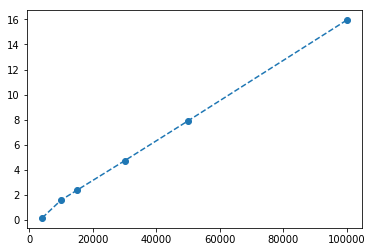

In [11]:
# change `time` with the results from the cell above in ``XXmin XXs`` format 
time = "15min 56s,07min 54s,04min 43s,02min 22s,01min 35s,00min39.1 s" 
time = [float(x[:2]) + float(x[6:-1]) / 60. for x in str(time).split(",")]

plt.plot(n_cells_list, time, label="scVI", marker='o', linestyle='--')

### Table 1. log likelihood

**NB:** Section (4.7) Evaluation, 3rd paragraph, last sentence


... In the case of an algorithm where the latent variable are actual parameters to optimize as in ZINB-WaVE, we need to re-run this partial optimization at testing-time...


This is what we do below with the `AdapterTrainer`

In [ ]:
# load dataset 
sample_size_gene_var = 10000 if n_epochs_all is None else 10
brainlarge_dataset = BrainLargeDataset(
    save_path=save_path, 
    sample_size_gene_var=sample_size_gene_var
)

# set hyperparameters 
n_epochs = 125 if n_epochs_all is None else n_epochs_all
lr = 0.001
use_batches = False
use_cuda = True

In [ ]:
n_cells_list = [100000, 50000, 30000, 15000, 10000, 4000]
for n_cells in n_cells_list:
    brainlarge_dataset.subsample_cells(n_cells) 
    brainlarge_vae = VAE(brainlarge_dataset.nb_genes, n_batch=brainlarge_dataset.n_batches * use_batches) 
    brainlarge_trainer = UnsupervisedTrainer(
        brainlarge_vae,
        brainlarge_dataset,
        train_size=0.5,
        use_cuda=use_cuda,
    ) 
    %time brainlarge_trainer.train(n_epochs=n_epochs, lr=lr)
    adapter_brainlarge_trainer = AdapterTrainer(brainlarge_vae, brainlarge_dataset, brainlarge_trainer.test_set)
    log_likelihood = adapter_brainlarge_trainer.train(n_path=1, n_epochs=1)
    print('log_likelihood: ' + str(log_likelihood))
    
    print(str(n_cells) + " cells log likelihood: " + str(log_likelihood)) 

### Figure 2. imputation (Uniform Corruption) 

In [5]:
# load dataset 
cortex_dataset = CortexDataset(save_path=save_path, total_genes=558)

# set hyperparameters 
n_epochs = 500 if n_epochs_all is None else n_epochs_all
lr = 0.0004
use_batches = False
use_cuda = True

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data



Median of Median: 2.3131
Mean of Median for each cell: 2.4907


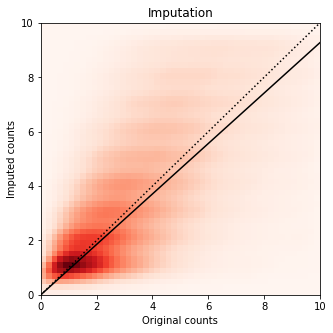

<Figure size 432x288 with 0 Axes>

In [9]:
# train the model

n_epochs=250 if n_epochs_all is None else n_epochs_all
lr=0.001
cortex_vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * use_batches)
trainer_cortex = UnsupervisedTrainer(
    cortex_vae,
    cortex_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
)

trainer_cortex.corrupt_posteriors(rate=0.09, corruption="uniform")
trainer_cortex.train(n_epochs=n_epochs)
trainer_cortex.uncorrupt_posteriors()

original_list, imputed_list = trainer_cortex.train_set.imputation_benchmark(
    n_samples=1,  
    show_plot=show_plot, 
    save_path=save_path,
)

### Figure 3. interpreting latent space; tsne plot and heatmap

Embedding plots: each point represents a cell and the layout is determined either by tSNE (CORTEX, ZINB) or (-> todo) by a 5-nearest neighbors graph visualized using a Fruchterman-Reingold force-directed algorithm> 

##### CORTEX tsne plot

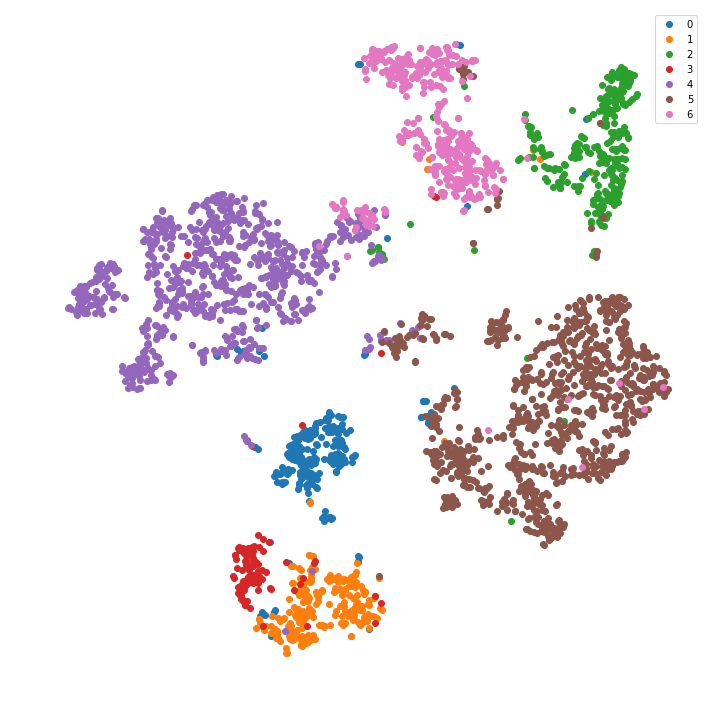

In [6]:
n_samples_tsne = 1000
trainer_cortex.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

CORTEX distance matrix heat map

In [ ]:
# celltypes = np.array(['astrocytes_ependymal', 'endothelial-mural', 'interneurons',
#        'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'],
#       dtype='|S64')
# beloved_order = np.array(['interneurons', 'pyramidal SS', 'pyramidal CA1', 'endothelial-mural', \
#  'microglia', 'astrocytes_ependymal', 'oligodendrocytes'])


# mapping = [np.where(beloved_order == x)[0][0] for x in celltypes]

# def visualize_distance(latent, labels, mapping):
#     sorting_labels = [mapping[int(x)] for x in c_train]
#     order_latent = np.vstack([x for _, x in sorted(zip(sorting_labels, latent), key=lambda pair: pair[0])])
#     order_label = np.vstack([x for _, x in sorted(zip(sorting_labels, labels), key=lambda pair: pair[0])])
    
#     distance = scipy.spatial.distance_matrix(order_latent, order_latent)  
    
#     fig = plt.figure(figsize=(10, 10)) 
#     gs = gridspec.GridSpec(2, 2, width_ratios=[1, 70], height_ratios=[1, 70])
#     gs.update(wspace=0.05, hspace=0.05)
#     ax0 = plt.subplot(gs[1])
#     ax0.imshow(order_label.T, cmap='tab10', interpolation='none', aspect=100)
#     ax0.axis('off')
#     ax1 = plt.subplot(gs[3], sharex=ax0)
#     ax1.imshow(distance, cmap='hot', interpolation='none')
#     ax1.axis('off')
#     ax2 = plt.subplot(gs[2], sharey=ax1)
#     ax2.imshow(order_label, cmap='tab10', interpolation='none', aspect=1/100.)
#     ax2.axis('off')
    
# visualize_distance(latent, c_train, mapping) # c_train is labels for training set 

HEMATO tsne plot - to reproduce the paper we should also use the5-nearest neighbors graph (Fruchterman-Reingold force-directed algorithm).

*NB:* The plot was originally displayed 

In [7]:
# load dataset 
hemato_dataset = HematoDataset(save_path=os.path.join(save_path, 'HEMATO/')) 

File data/HEMATO/bBM.raw_umifm_counts.csv.gz already downloaded
File data/HEMATO/data.zip already downloaded
Preprocessing Hemato data
Finished preprocessing Hemato data


In [8]:
# set hyperparameters 
n_epochs=200 if n_epochs_all is None else n_epochs_all
lr=0.0004
use_batches=False
use_cuda=True

# train the model 
hemato_vae = VAE(hemato_dataset.nb_genes, n_batch=hemato_dataset.n_batches * use_batches)
hemato_trainer = UnsupervisedTrainer(hemato_vae,
                                     hemato_dataset,
                                     train_size=0.9, 
                                     use_cuda=use_cuda, 
                                     frequency=5)
hemato_trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [01:45<00:00,  1.89it/s]


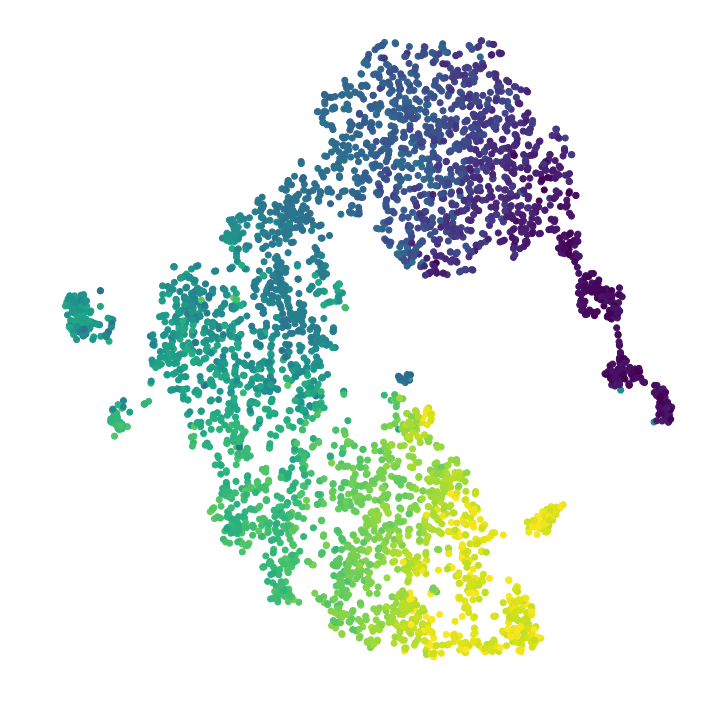

In [9]:
# visualize latent space 
hemato_trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='scalar')

HEMATO distance matrix heat map

In [ ]:
# visualize_distance(latent_scVI, logit(meta.iloc[:, 2]), "scVI")

ZINB 

In [12]:
# generate random data 
n_cells = 3000 
n_genes = 10 
n_clusters = 11 

mu = 4.0
theta = 2.0
dropout = 0.7
p = mu / (mu + theta)
r = theta 

l_train = np.random.gamma(r, p / (1-p), size=(n_cells, n_genes))
expression = np.random.poisson(l_train)
expression *= np.random.binomial(1, 1-dropout, size=(n_cells, n_genes))
expression = expression[np.sum(expression, axis=1) > 0]
labels = np.random.randint(0, n_clusters, size=expression.shape[0])
cell_types = ["%d" % i for i in range(n_clusters)]

zinb_dataset = GeneExpressionDataset()
zinb_dataset.populate_from_data(X=expression, labels=labels, cell_types=cell_types)

In [13]:
# set hyperparameters 
n_epochs=200 if n_epochs_all is None else n_epochs_all
lr=0.0004
use_batches=False
use_cuda=True

# train the model 
zinb_vae = VAE(zinb_dataset.nb_genes, n_batch=zinb_dataset.n_batches * use_batches)
zinb_trainer = UnsupervisedTrainer(zinb_vae, 
                                   zinb_dataset, 
                                   train_size=2/3,
                                   use_cuda=use_cuda, 
                                   frequency=5)
zinb_trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [00:27<00:00,  7.22it/s]


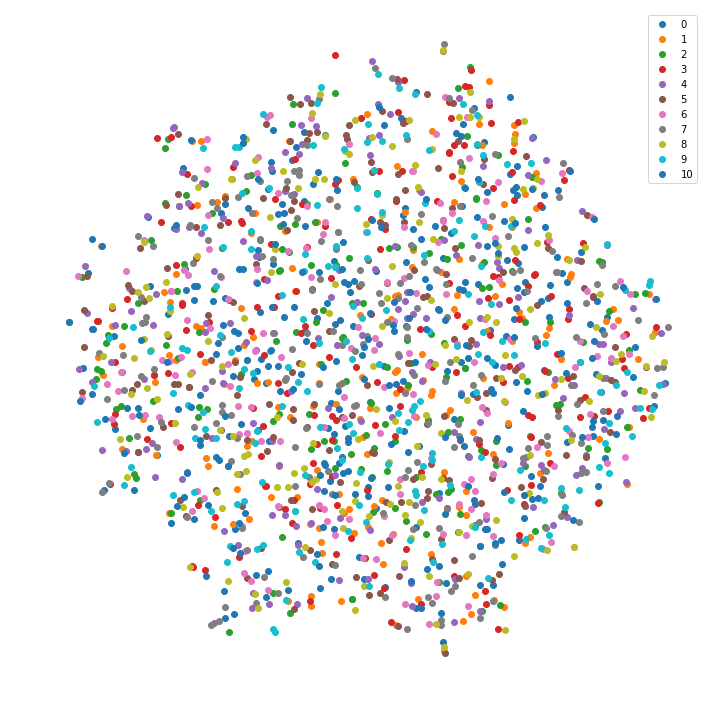

In [14]:
# visualize latent space  
zinb_trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels') 

ZINB Distance Matrix Heat Map

In [ ]:
# def visualize_distance(latent, labels, algorithm):
#     order_latent = np.vstack([x for _, x in sorted(zip(labels,latent), key=lambda pair: pair[0])])
#     order_label = np.vstack([y for y, x in sorted(zip(labels,latent), key=lambda pair: pair[0])])
#     distance = scipy.spatial.distance_matrix(order_latent, order_latent)  
    
#     fig = plt.figure(figsize=(10, 10)) 
#     gs = gridspec.GridSpec(2, 2, width_ratios=[1, 70], height_ratios=[1, 70])
#     gs.update(wspace=0.05, hspace=0.05)
#     ax0 = plt.subplot(gs[1])
#     ax0.imshow(order_label.T, cmap='Dark2', interpolation='none', aspect=100)
#     ax0.axis('off')
#     ax1 = plt.subplot(gs[3], sharex=ax0)
#     ax1.imshow(distance, cmap='hot', interpolation='none')
#     ax1.axis('off')
#     ax2 = plt.subplot(gs[2], sharey=ax1)
#     ax2.imshow(order_label, cmap='Dark2', interpolation='none', aspect=1/100.)
#     ax2.axis('off')
#     #plt.tight_layout()
#     fig.suptitle("Cell-Cell Similarity matrix on the "+ algorithm + " latent space", fontsize=16, y=0.92) 
    
# visualize_distance(latent_scVI, labels, "scVI") 

### Figure 4. batch effect removal; tsne plot

In [4]:
# load retina dataset 
retina_dataset = RetinaDataset(save_path=save_path)

File data/retina.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [5]:
# set hyperparameters 
n_epochs=200 if n_epochs_all is None else n_epochs_all
lr=0.0005
use_batches=True
use_cuda=True

# train the model
retina_vae = VAE(retina_dataset.nb_genes, n_batch=retina_dataset.n_batches * use_batches)
retina_trainer = UnsupervisedTrainer(retina_vae,
                                 retina_dataset,
                                 train_size=0.9,
                                 use_cuda=use_cuda,
                                 frequency=5)
retina_trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [20:04<00:00,  6.02s/it]


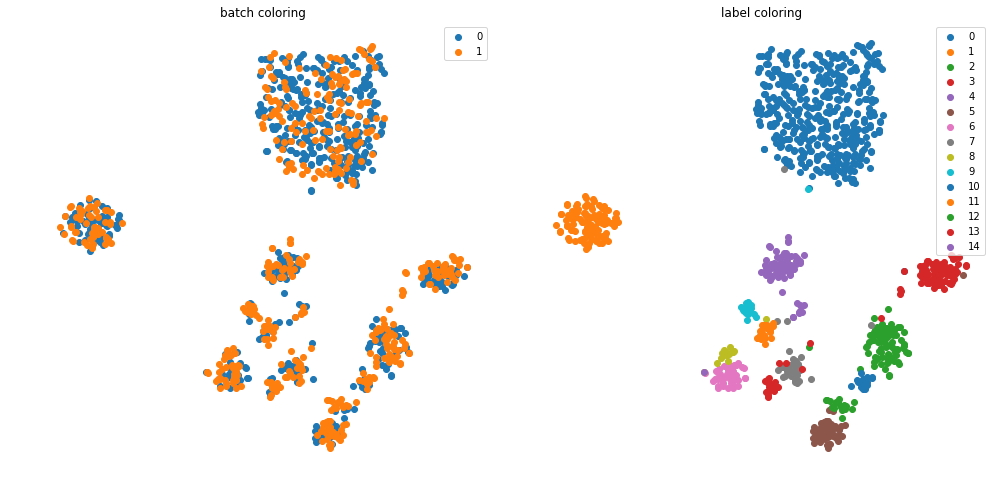

In [6]:
# visualize latent space 
retina_trainer.train_set.show_t_sne(n_samples_tsne, color_by='batches and labels')

### Figure 5. differential expression; plots

Benchmark of differential expression analysis using the PBMC dataset, based on consistency with published bulk data. 

#### (a, b) (Not shown here) Irreproducible Discovery Rate (IDR) and AUROC 

Evaluation of consistency with the irreproducible discovery rate (IDR) [37] framework (blue) and using AUROC (green) is shown for comparisons of B cells vs Dendritic cells (please ref to https://github.com/romain-lopez/scVI-reproducibility/)

#### (a, b) (Not shown here) Irreproducible Discovery Rate (IDR) and AUROC 

In [6]:
import scipy
import scipy.stats as stats


def process_proba(logit_dropout, mean=None, dispersion=None):
    p = 1 / (1 + np.exp(- logit_dropout))
    if mean is not None:
        p = (1 - p) / scipy.special.gamma(dispersion) * np.power(dispersion / (dispersion + mean), dispersion)

    p[p > 1] = np.max(p[p < 1])
    p[p == 0] = np.min(p[p > 0])

    return p


def normalize_plot(x, y, z, s="", logit=True, normalize=True, plot=True):
    """
    plot to verify that x and y is correlated with z
    """
    
    if logit:
        # take logits before averaging
        x = np.log(x / (1-x))
        y = np.log(y / (1-y))
        
    # test shapes
    if z.shape[0] == x.shape[0]:
        #average across genes
        x = np.mean(x, axis=1)
        y = np.mean(y, axis=1)
    
    elif z.shape[0] == x.shape[1]:
        # we got a gene problem, ave ac. cells
        x = np.mean(x, axis=0)
        y = np.mean(y, axis=0)
    
    else: 
        print("Wrong shapes !")
    
    if normalize:
        # normalization workflow
        x = x - np.mean(x)
        x = np.ma.divide(x, np.std(x)).filled(0)
        y = y - np.mean(y)
        y = np.ma.divide(y, np.std(y)).filled(0)
        z = z - np.mean(z)
        z = np.ma.divide(z, np.std(z)).filled(0)
    
    if plot:
        # scattering workflow
        f, axarr = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
        axarr[0].scatter(x, z, alpha=0.5)
        axarr[1].scatter(y, z, alpha=0.5)
    
    if normalize:
        if plot:
            axarr[0].axis((-3,3,-3,3))
            axarr[1].axis((-3,3,-3,3))   
        # regression workflow
        a_x, intercept, r_value_x, p_value_x, std_err = stats.linregress(x,z)
        
        if plot:
            l = np.linspace(-3, 3)
            axarr[0].plot(l, a_x * l, color='black')
            supp = "a={0:.2f} \np={1:.1e}".format(a_x, p_value_x)
            if a_x >0.1:
                axarr[0].text(1, -2.2, supp, fontsize=12)
            else:
                axarr[0].text(1, 2.2, supp, fontsize=12) 
            
        a_y, intercept, r_value_y, p_value_y, std_err = stats.linregress(y,z)
        
        if plot:
            supp = "a={0:.2f} \np={1:.1e}".format(a_y, p_value_y)
            l = np.linspace(-3, 3)
            axarr[1].plot(l, a_y * l, color='black')
            if a_y >0.1:
                axarr[1].text(1, -2.2, supp, fontsize=12)
            else:
                axarr[1].text(1, 2.2, supp, fontsize=12) 
      
    if plot:
        axarr[0].set_xlabel("Bernouilli zero prob")
        axarr[1].set_xlabel("NB zero prob")
        axarr[0].set_ylabel(s)

    return a_x, r_value_x, a_y, r_value_y

In [14]:
# load dataset 
pbmc_dataset = PbmcDataset(save_path=save_path, save_path_10X=os.path.join(save_path, "10X"))
pbmc_dataset.dense = True

File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/10X/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Preprocessing dataset
Extracting tar file
Finished preprocessing dataset
Keeping 33694 genes
Downsampling from 12721 to 11990 cells
Downsampling from 33694 to 3346 genes
Downsampling from 11990 to 11990 cells


In [15]:
# set hyperparameters 
from scvi.inference import UnsupervisedTrainer
n_epochs=1
lr=0.0004
use_batches=False
use_cuda=True

# train the model
pbmc_vae = VAE(pbmc_dataset.nb_genes, n_batch=pbmc_dataset.n_batches * use_batches, dropout_rate=0.2)
pbmc_trainer = UnsupervisedTrainer(pbmc_vae, 
                                   pbmc_dataset,
                                   train_size=1.0,
                                   use_cuda=use_cuda,
                                   n_epochs_kl_warmup=None)
pbmc_trainer.train(n_epochs=n_epochs, lr=lr, eps=0.01) 

training: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


In [28]:
import pandas as pd
interest = "BDC"
couple_celltypes = (4, 0) # 4 
rank_auc = 800
p_prior = 0.25

# getting p_values
p_value = pbmc_dataset.de_metadata[interest + "_adj.P.Val"]
signed_p_value = - np.log10(p_value) * np.sign(pbmc_dataset.de_metadata[interest + "_logFC"])

cell_a_idx = (pbmc_dataset.labels==4).ravel()
cell_b_idx = (pbmc_dataset.labels==0).ravel()
pbmc_trainer.posterior = pbmc_trainer.create_posterior(
    indices=np.arange(len(pbmc_dataset))
)
n_samples = 300
M_permutation = 40000
st = pbmc_trainer.posterior.differential_expression_score(
    cell_a_idx, 
    cell_b_idx,
    n_samples=n_samples, 
    M_permutation=M_permutation, 
    all_stats=False,
)

BDC
Detected  1077  genes with scVI
Detected  879  genes with microarray


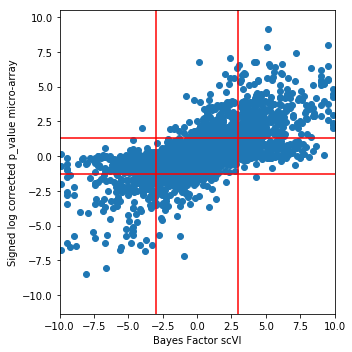

In [18]:
plt.figure(figsize=(5, 5))
plt.scatter(st, signed_p_value)
plt.axvline(x=3, c="r")
plt.axvline(x=-3, c="r")
plt.axhline(y=np.log10(0.05), c="r")
plt.axhline(y=-np.log10(0.05), c="r")
plt.xlim(-10,10)
plt.xlabel("Bayes Factor scVI")
plt.ylabel("Signed log corrected p_value micro-array")
plt.tight_layout()
# plt.savefig(interest + "_Bayes_factor_vs_micro_array.pdf", dpi=300)
print(interest)
print("Detected ", np.sum(2 * np.abs(st) >= 6), " genes with scVI")
print("Detected ", np.sum(p_value <= 0.05), " genes with microarray")

### Figure 6. plots 

Capturing technical variability with the parameters of scVI. Data for panels a-b is based on the CD14+ cell subpopulation in the PBMC dataset.

#### (a) Scatter plot for each cell of inferred scaling factor by scVI against library size.

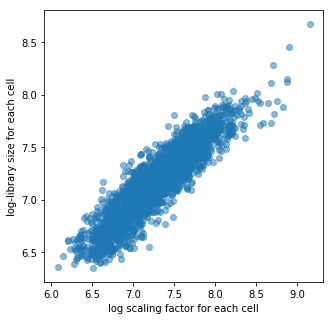

In [5]:
plt.figure(figsize=(5, 5))

cd14_posterior = pbmc_trainer.create_posterior(indices=(pbmc_dataset.labels==1).ravel())
libraries = cd14_posterior.get_stats().ravel()

cd14_raw_data = cd14_posterior.raw_data()[0].A
plt.scatter(libraries, np.log(np.sum(cd14_raw_data, axis=1)), alpha=0.5)
plt.xlabel('log scaling factor for each cell')
plt.ylabel('log-library size for each cell')


#### (b) The frequency of observed zero values versus the expected expression level, as produced by scVI. 

Each point represents a gene g, where the x-axis is ρg - the average expected frequency per cell (for gene g, average over ρgc for all cells c in the subpopulation), and the y-axis the is observed percentage of cells that detect the fee (UMI>0). The cyan curve depicts the probability for selecting zero transcripts from every gene as a function of its frequency, assuming a simple model of sampling U molecules from a cell with N molecules at random without replacement, where U = 1398 is the average number of UMIs in the subpopulation. The hypergeometric distribution (inset) requires the average number of transcripts per cell (N). Notably the curve converges for values larger than 20k (here, we set N = 10k). Indeed, when N → ∞ the process converges to a binomial selection procedure, which is depicted by the red line.

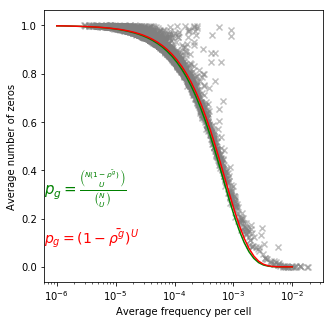

In [7]:
from scipy.stats import hypergeom, binom

dropout_list, mean_list, dispersion_list = cd14_posterior.generate_parameters()

# number of molecules against number of zero (points are genes)
scaling = 1
m =  scaling * np.mean(mean_list / np.exp(libraries.reshape(-1,1)), axis=0)
p = np.mean(cd14_raw_data == 0, axis=0)

mask = (p > 0) * (m < scaling * 0.03)

m = m[mask]
p = p[mask]


c = ["green", "green", "red", "purple"]

plt.figure(figsize=(5, 5))
l = np.logspace(-6, -2)

N = 10000
plt.plot(l, [hypergeom.pmf(0, N, N*rho, 1398) for rho in l], color=c[1] )
plt.text(0.0000006, 0.3, r"$p_g = \frac{\binom{N(1-\bar{\rho^g})}{U}}{\binom{N}{U}}$", fontsize=15, color=c[1])

plt.plot(l, [binom.pmf(0, 1398, rho) for rho in l], color=c[2] )
plt.text(0.0000006, 0.1, r"$p_g = (1-\bar{\rho^g})^U$", fontsize=14, color=c[2])

plt.gca().set_xscale("log", nonposx='clip')


plt.xlabel('Average frequency per cell')
plt.ylabel('Average number of zeros')

plt.scatter(m, p, alpha=0.5, color="grey", marker="x")

#### (c, d) Correlation between zero probabilities and quality control metrics

Signed log p-values for testing correlations between the zero probabilities from the two distributions (negative binomial, Bernoulli) and quality control metrics across five random initializations of scVI and all subpopulations of the PBMC and the BRAIN-SMALL datasets.

In [4]:
# PBMC
import matplotlib.patches as mpatches


def finite(x):
    return x[np.isfinite(x)]


use_batches = False
lr=1e-4


def zero_distributions_qc_correlation_plot(dataset, trials=2):
    list_plots = [None for _ in range(5)]
    trials = 2

    qc_names = dataset.qc_names  # The name of the qc metrics are the columns of the qc dataframe

    list_plots = ["emp_gene_detection", "emp_lib_size", qc_names[2], qc_names[4], qc_names[5]]
    list_cell_types = np.unique(dataset.labels)
    n_epochs = 1
    res = np.zeros((trials, len(list_cell_types), len(list_plots), 4))
    for t in range(trials):
        # train the model for each random seed
        vae = VAE(dataset.nb_genes, n_batch=dataset.n_batches * use_batches, dropout_rate=0.2)
        trainer = UnsupervisedTrainer(vae, dataset, train_size=1.0)
        trainer.train(n_epochs=n_epochs, lr=lr, eps=0.01) 

        # then perform the analysis for each cell type
        for k in list_cell_types:        
            posterior = trainer.create_posterior(indices=(dataset.labels==k).ravel())
            if not dataset.dense:
                data = posterior.raw_data()[0].A
            else:
                data = posterior.raw_data()[0]

            dropout, mean, dispersion = posterior.generate_parameters()
            qc = dataset.raw_qc.values[posterior.indices]

            # Here 5 stats are computed
            res[t, k, 0] = normalize_plot(
                process_proba(dropout),
                process_proba(dropout, mean, dispersion), 
                np.squeeze(np.asarray(np.sum(data > 0, axis=1))), 
                s="number of gene detected", 
                plot=False,
            )
            res[t, k, 1] = normalize_plot(
                process_proba(dropout),
                process_proba(dropout, mean, dispersion), 
                np.squeeze(np.asarray(np.log(np.sum(data, axis=1)))), 
                s="log average counts per cells",  
                plot=False,
            )
            for i, qc_number in enumerate([2, 4, 5]):
                res[t, k, 2 + i] = normalize_plot(
                    process_proba(dropout), 
                    process_proba(dropout, mean, dispersion), 
                    qc[:, qc_number], 
                    qc_names[qc_number], 
                    plot=False,
                )
    cell_type_counts = np.unique(dataset.labels.ravel(), return_counts=True)[1]

    t_stats = np.zeros((trials, len(list_cell_types), len(list_plots), 2))
    p_values = np.zeros_like(t_stats)
    # get the t_stats from the regression value
    for t in range(trials):
        for k in range(len(list_cell_types)):
            for i in range(len(list_plots)): # 5 plots
                for j in range(2):
                    r = res[t, k, i, 2*j +1]
                    n = cell_type_counts[k]
                    t_stats[t, k, i, j] = r * np.sqrt((n - 2)/(1 - r**2))
                    p_values[t, k, i, j] = 2 * scipy.stats.distributions.t.sf(np.abs(t_stats[t, k, i, j]), n)

    p_values = p_values.reshape((trials * len(list_cell_types), len(list_plots), 2))
    t_stats = t_stats.reshape((trials * len(list_cell_types), len(list_plots), 2))
    log_p = np.ma.log10(p_values).filled(-np.inf)
    scores = - np.sign(t_stats) * log_p
    
    list_plots = ["% Gene detection", "Library size",
                  "Mean reads per UMI", "% Mapped reads", "% Genome not gene"]

    data_1 = [finite(scores[:, i, 0]) for i in [0, 1, 2]]
    data_1b = [finite(scores[:, i, 1]) for i in [0, 1, 2]]

    props = dict(widths=0.2,patch_artist=True, medianprops=dict(color="black"), whis=[5, 95], sym="")
    fig, ax1 = plt.subplots(figsize=(7, 5))
    ax1.hlines(y=0, xmin=-0.5, xmax=2.5, color='blue', zorder=1)    
    ax1.set_ylabel('p-value for correlation with library size QC', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()

    bp1 = ax1.boxplot(data_1, positions=[0, 1, 2], **props)
    bp1b = ax1.boxplot(data_1b, positions=[0.2, 1.2, 2.2], **props)
    ax1.hlines(y=0, xmin=-0.5, xmax=2.5, color='blue', zorder=1)
    for patch in bp1['boxes']:
        patch.set_facecolor('lightblue')
    for patch in bp1b['boxes']:
        patch.set_facecolor('c')

    data_2 = [finite(scores[:, i, 0]) for i in [3, 4]]
    data_2b = [finite(scores[:, i, 1]) for i in [3, 4]]
    ax2.hlines(y=0, xmin=2.5, xmax=5, color='green', zorder=1)
    ax2.set_ylabel('p-value for correlation with alignment QC', color='g')
    ax2.tick_params('y', colors='g')
    bp2 = ax2.boxplot(data_2, positions=[3, 4], **props)
    bp2b = ax2.boxplot(data_2b, positions=[3.2, 4.2], **props)
    for patch in bp2['boxes']:
        patch.set_facecolor('lightgreen')
    for patch in bp2b['boxes']:
        patch.set_facecolor('lime')

    ax1.set_xlim((-0.5, 5))
    ax1.set_xticks([0, 1, 2, 3, 4])
    ax1.set_xticklabels([list_plots[i] for i in [0, 1, 2, 3, 4]], rotation=30)

    m1, = plt.plot([], [], c='lightblue' , marker='s', markersize=15,
                   fillstyle='left', linestyle='none')
    m2, = plt.plot([], [], c='lightgreen' , marker='s', markersize=15,
                   fillstyle='right', linestyle='none')
    m3, = plt.plot([], [], c='c' , marker='s', markersize=15,
                   fillstyle='left', linestyle='none')
    m4, = plt.plot([], [], c='lime' , marker='s', markersize=15,
                   fillstyle='right', linestyle='none')

    # ---- Plot Legend ----

    plt.legend(((m2, m1), (m3, m4)), ('Ber',"NB"), numpoints=1, labelspacing=1, fontsize=12, loc="lower right")

    fig.suptitle("Zero distribution vs cell quality metrics (%s)"%dataset.__class__.__name__)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
brain_small_dataset = BrainSmallDataset(save_path=save_path, save_path_10X=os.path.join(save_path, "10X"))
brain_small_dataset.subsample_genes(3000)
brain_small_dataset.dense=True
brain_small_dataset.X = np.ascontiguousarray(brain_small_dataset.X.A, dtype=np.float32)

n_epochs = 200 if n_epochs_all is None else n_epochs_all
vae = VAE(brain_small_dataset.nb_genes)
brain_small_trainer = UnsupervisedTrainer(vae, brain_small_dataset)
brain_small_trainer.train(n_epochs)

In [ ]:
# don't run this on unit tests, some p_values can be gargage and cause instability
if n_epochs_all is None:
    zero_distributions_qc_correlation_plot(brain_small_dataset)

In [ ]:
zero_distributions_qc_correlation_plot(pbmc_dataset)

### Figure 7. posterior plots

In [6]:
mapping = lambda x: np.log(1 + x / 10.)
inv_mapping = lambda x: (np.exp(x) - 1) * 10


def draw_custom_hist_data(x, y):
    
    # First digitize the original values
    # makes a K x K matrix
    K = 15
    hist, count_bins = np.histogram(mapping(y), bins=K)
    y_bin_assign = np.digitize(mapping(y), count_bins)
    
    # now we get for each value and for each eventual posterior the histogram assignment
    x_bin_assign = np.digitize(mapping(x), count_bins)
    
    # print np.unique(y_bin_assign)
    # Let us construct the full matrix to visualize
    
    mat = np.zeros(shape=(K, K))
    for k in range(1, K+1):
        assign_slice = x_bin_assign[y_bin_assign == k].flatten()
        assign_slice = assign_slice[assign_slice > 0]
        assign_slice = assign_slice[assign_slice < K+1]
        for i in range(1, K+1):
            assign_slice = np.append(assign_slice, i)
        # print np.unique(assign_slice)
        _, mat[k-1] = np.unique(assign_slice, return_counts=True)
        
    # print mat
    mat = mat / np.sum(mat, axis=0)
    plt.xticks(np.arange(mat.shape[0])[::2], inv_mapping(count_bins).astype(np.int)[::2])
    plt.yticks(np.arange(mat.shape[0])[::2], inv_mapping(count_bins).astype(np.int)[::2])
    plt.imshow(mat.T, origin='lower', interpolation="none")

training: 100%|██████████| 250/250 [00:46<00:00,  5.40it/s]


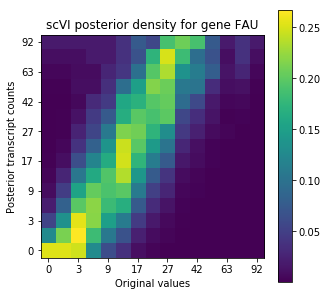

In [10]:
n_epochs=250 if n_epochs_all is None else n_epochs_all
lr=0.001
cortex_vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * use_batches)
trainer_cortex = UnsupervisedTrainer(
    cortex_vae,
    cortex_dataset,
    train_size=0.9,
    use_cuda=use_cuda,
)
trainer_cortex.train(n_epochs=n_epochs)


n_samples_posterior_density=30 # 250 is scVI-reproducibility
x, y = trainer_cortex.train_set.generate(genes=['FAU'], n_samples=n_samples_posterior_density) 
# "THY1" ?  253 => FAU in gene names index

x = x.squeeze()
y = y.squeeze()

plt.figure(figsize=(5, 5))
draw_custom_hist_data(x, y)
plt.title("scVI posterior density for gene FAU")
plt.xlabel("Original values")
plt.ylabel("Posterior transcript counts")
plt.colorbar()

Text(0,0.5,'scVI posterior uncertainty')

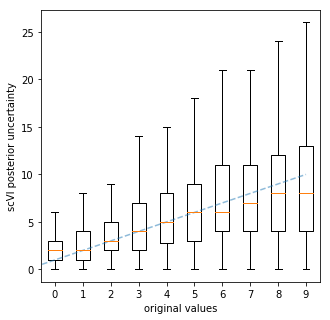

In [11]:
data = [x[y == t].flatten() for t in range(0, 10)]
plt.figure(figsize=(5, 5))
plt.boxplot(data, sym="")
plt.xticks(range(1, 11), range(0, 10))


l = np.linspace(0, 10, 50)
plt.plot(l, l, linestyle="--", alpha=0.5)
plt.xlabel("original values")
plt.ylabel("scVI posterior uncertainty")

### Figure 8. silhouette and batch mixing entropy 

In [11]:
def barplot(mean, alg, title, save=None, interest=0):
    N = 4

    ind = np.arange(len(alg))  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    rects1 = ax.barh(ind, mean, width, color='r')
    if interest > 0:
        func = np.min
    else:
        func = np.max
    ax.axvline(x=func(mean), ymin=0, ymax = 5, linewidth=1, color='b')

    # add some text for labels, title and axes ticks
    ax.set_xlabel(title)
    ax.set_yticks(ind)
    ax.set_yticklabels(alg)


def barplot_CITE_list(mean, alg, title, save=None, interest=0, figsize=None):
    
    ind = np.arange(len(alg))  # the x locations for the groups
    width = 0.25       # the width of the bars
    
    if figsize is None:
        fig, ax1 = plt.subplots()
    else:
        fig, ax1 = plt.subplots(figsize=figsize)
    rect1 = ax1.barh(ind, data[0], width, color="b")
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_xlabel('Spearman Correlation', color='b')
    ax1.tick_params('x', colors='b')    
    
    ax2 = ax1.twiny()
    rect2 = ax2.barh(ind + width, data[1], width, color="r")
    ax2.set_xlabel('Fold Enrichment', color='r')
    ax2.tick_params('x', colors='r')

    ax1.set_title(title, y=-0.3)
    ax1.set_yticks(ind + width)
    ax1.set_yticklabels(alg)
    plt.tight_layout()
    
    
def barplot_list(data, alg, title, save=None, interest=0, prog=False, figsize=None):
    ind = np.arange(len(alg))  # the x locations for the groups
    width = 0.25       # the width of the bars
    if figsize is None:
        fig = plt.figure()

    else:
        fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    if len(data[0]) == 3:
        width = 0.25       # the width of the bars
    
    else:
        width = 0.15
          
    rects = [] 
    color = ["r", "g", "y", "b", "purple"]
    if prog:
        color = ['darkred', "red", "tomato", "salmon"]
    for i in range(len(data[0])):    
        rects.append(ax.barh(ind + i * width, data[:,i], width, color=color[i]))
        
    anchor_param = (0.8, 0.8)
    leg_rec = [x[0] for x in rects]
    leg_lab = ('ASW', 'ARI', 'NMI', "BE", "BASW")
    if prog:
        leg_lab = ["2", "3", "4", "7"]
    ax.legend(leg_rec, leg_lab[:len(data[0])] )

    # add some text for labels, title and axes ticks
    ax.set_xlabel(title)
    ax.set_yticks(ind + width)
    ax.set_yticklabels(alg)
    plt.tight_layout()

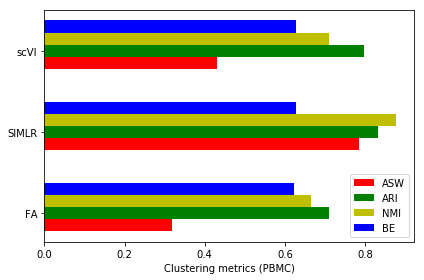

In [89]:
# (a) PBMC
asw, nmi, ari, uca = pbmc_trainer.train_set.clustering_scores()
be = pbmc_trainer.train_set.entropy_batch_mixing()
# asw, ari, nmi, be = .42970678, 0.79660054333307828, 0.70952528367336209, 0.627160634386 # in scVI-reproducibility
alg = ["FA", "SIMLR", "scVI"]
data = np.array([[0.31893232823756423, 0.70949147594234441, 0.6639320594878495, 0.622334973356],\
        [0.78464960298125097, 0.83127101206256038, 0.87814668767539328, 0.628411486367],\
        [asw, ari, nmi, be]])

barplot_list(data, alg, 'Clustering metrics (PBMC)')

training: 100%|██████████| 400/400 [01:14<00:00,  5.34it/s]
Clustering Scores:
Silhouette: 0.2109
NMI: 0.7406
ARI: 0.6935
UCA: 0.7641
0.21088849 0.7405945587161528 0.6934866493706187 0.7640532544378699


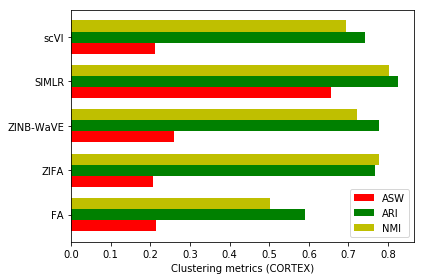

In [14]:
# (b) CORTEX Clustering Metrics 
alg = ["scVI"] 

alg = ["FA", "ZIFA", "ZINB-WaVE", "SIMLR", "scVI"]

n_epochs=250 if n_epochs_all is None else n_epochs_all
lr=0.001
cortex_vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * use_batches)
trainer_cortex = UnsupervisedTrainer(
    cortex_vae,
    cortex_dataset,
    train_size=0.75,
    use_cuda=use_cuda,
)
trainer_cortex.train(n_epochs)
asw, nmi, ari, uca = trainer_cortex.train_set.clustering_scores()
print(asw, nmi, ari, uca)
# asw, nmi, ari = 0.2997168, 0.77794597391165898, 0.7444437120757863 # in scVI-reproducibility

data = np.array([[0.21391998556424938, 0.59116624750943825, 0.50231747503265922], \
        [0.20659129809077773, 0.76804626919745633, 0.77806177522581543], \
        [0.26024010642172596, 0.77821596684230276, 0.72163060519162336], \
        [0.65496546363239816, 0.82448501471354962, 0.80190025231822593], \
        [asw, nmi, ari]])
barplot_list(data, alg, 'Clustering metrics (CORTEX)')

File data/citeSeq/cbmc/cbmc_rna.csv.gz already downloaded
File data/citeSeq/cbmc/cbmc_adt.csv.gz already downloaded
File data/citeSeq/cbmc/cbmc_adt_centered.csv.gz already downloaded
Preprocessing data
Selecting only HUMAN genes (20400 / 36280)
Finish preprocessing data
training: 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]
Overlap Scores:
Spearman Correlation: 0.1415
Fold Enrichment: 10.0041


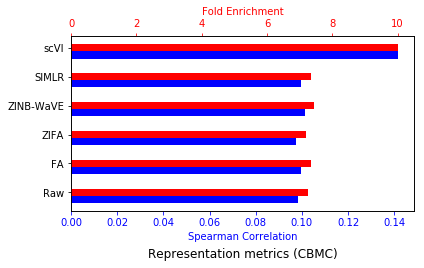

In [15]:
# (c) CBMC Representation Metrics 
cbmc_dataset = CbmcDataset(save_path=os.path.join(save_path, 'citeSeq/'))

n_epochs = 100 if n_epochs_all is None else n_epochs_all
vae = VAE(cbmc_dataset.nb_genes)
trainer_cbmc = UnsupervisedTrainer(vae, cbmc_dataset, train_size=0.75)
trainer_cbmc.train()

spearman_correlation_scvi, fold_enrichement_scvi = trainer_cbmc.train_set.nn_overlap_score()
# spearman_correlation_scvi, fold_enrichement_scvi = 0.10619144922991411,  7.7559 # in scVI-reproducibility
alg = ["Raw", "FA", "ZIFA", "ZINB-WaVE", "SIMLR", "scVI"]
data = np.array([[0.098473750393067855, 7.2649], \
         [0.099746934926233391, 7.3459],\
         [0.097387613957984093, 7.1958], \
         [0.10141150581589038, 7.4518], \
         [0.099619616472917824, 7.3378], \
        [spearman_correlation_scvi, fold_enrichement_scvi]]).T
barplot_CITE_list(data, alg, 'Representation metrics (CBMC)')

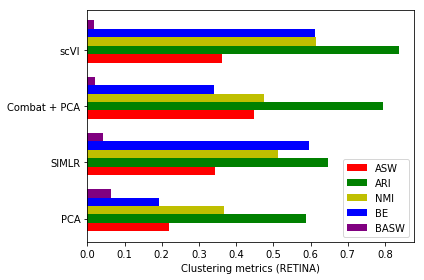

In [77]:
# (d) RETINA Clustering Metrics 
retina_dataset = RetinaDataset(save_path=save_path) 

n_epochs = 100 if n_epochs_all is None else n_epochs_all

vae = VAE(retina_dataset.nb_genes)
retina_trainer = UnsupervisedTrainer(vae, retina_dataset)
retina_trainer.train(n_epochs)

asw, nmi, ari, uca = retina_trainer.train_set.clustering_scores()
be = retina_trainer.train_set.entropy_batch_mixing()

# In scVI-reproducibility
# asw = 0.36126289
# ari = 0.83652908297624851
# nmi = 0.61592297966666154
# be = 0.61157293916
basw = 0.0185152 # not computed here

retina_data = np.array([[0.21954027735402515, 0.58685860355428821, 0.36856986097377797, 0.192647888467, 0.0624201044534],\
        [0.34417779654030661, 0.64755125928853896, 0.51136144259466121, 0.597048161687, 0.0409665873338],\
        [0.44694698300835106, 0.794144880698191, 0.47583467153476738, 0.34069311837, 0.019781812657], \
        [asw,ari,nmi,be,basw]])
alg = ["PCA", "SIMLR", "Combat + PCA", "scVI"]

barplot_list(retina_data, alg, 'Clustering metrics (RETINA)')

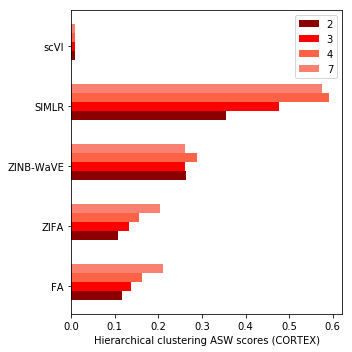

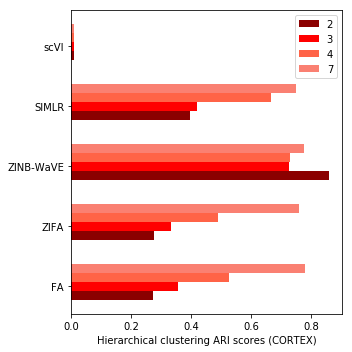

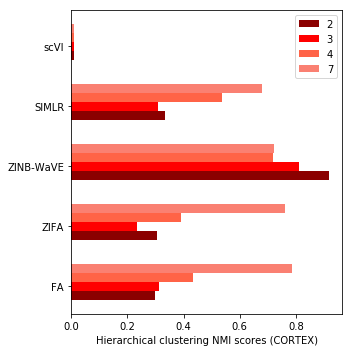

In [50]:
# (e) (f) (g) CORTEX Hierarchical Clustering Scores 

alg = ["FA","ZIFA","ZINB-WaVE","SIMLR", "scVI"]

scVI = np.array([[0.01,0.01, 0.01],
[0.01,0.01, 0.01],
[0.01, 0.01, 0.01],
[0.01, 0.01, 0.01]]).T
simlr = np.array([[0.35581114086547649, 0.39763026135241941, 0.33581111107441836],
[0.47594514783811925, 0.42182382206636898, 0.30828147637529074],
[0.59177936314164903, 0.667961741036047, 0.53600416126351158],
[0.57610561187014786, 0.75222293463073531, 0.67924145540151004]]).T
zinb = np.array([[0.26307611328993241, 0.86133243308042906, 0.91825852643537653],
[0.26120556769903069, 0.72846126262601396, 0.81089804731570525],
[0.28948372843281256, 0.7307396743553678, 0.71783886252317064],
[0.26175088291560739, 0.77674732406327229, 0.72310898818408831]]).T
zifa = np.array([[0.10760864940650154, 0.27739547166803474, 0.3047726295034825],
[0.13207018700791912, 0.33238196759272998, 0.23560128683050038],
[0.15602621812120895, 0.4890464265132512, 0.39260959628267939],
[0.20493195811497675, 0.7621022202234099, 0.76261580271279172]]).T
fa = np.array([[0.11581131621741773, 0.27312842428258505, 0.29890142393022651],
[0.13797953173246824, 0.35827752246474137, 0.31243455865964415],
[0.16330256646100386, 0.5281002482621574, 0.43436435453448607],
[0.21151757370266544, 0.78013724807955642, 0.78688963604064266]]).T

data = np.concatenate([arr[np.newaxis,:,:] for arr in [fa,zifa,zinb,simlr,scVI]])

for i, l in enumerate(["ASW", "ARI", "NMI"]):
    barplot_list(data[:,i,:], alg, 'Hierarchical clustering ' + l +' scores (CORTEX)', prog=True, figsize=(5, 5))

### Figure 9. Cortex Likelihood & imputation with uniform perturbation scheme

- todo: add the summary of all the **uniform** imputation benchmarks (PBMC, RETINA, CORTEX, BRAIN-LARGE, HEMATO), computed elsewhere in the notebook.

(a) Log-likelihood results on the CORTEX dataset. (b) through (d): we investigate how scVI latent space can be used to impute the data (with the uniform perturbation scheme) and report benchmarking across datasets for state-of-the-art methods


**NB:** Section (4.7) Evaluation, 3rd paragraph, last sentence


... In the case of an algorithm where the latent variable are actual parameters to optimize as in ZINB-WaVE, we need to re-run this partial optimization at testing-time...


This is what we do below with the `AdapterTrainer`

In [10]:
 # set hyperparameters 
n_epochs=40 if n_epochs_all is None else n_epochs_all
lr=0.0004
use_batches=False
use_cuda=True

cortex_vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * use_batches)
trainer_cortex = UnsupervisedTrainer(cortex_vae,
                                     cortex_dataset,
                                     train_size=0.6,
                                     use_cuda=use_cuda)

trainer_cortex.train(n_epochs=n_epochs)
adapter_trainer_cortex = AdapterTrainer(cortex_vae,cortex_dataset, trainer_cortex.test_set)
log_likelihood = adapter_trainer_cortex.train(n_path=3, n_epochs=10)
print('log_likelihood: ' + str(log_likelihood))

training: 100%|██████████| 400/400 [00:48<00:00,  8.19it/s]
2.3002048


In [19]:
datasets = [cortex_dataset, 
            retina_dataset, 
            pbmc_dataset, 
            hemato_dataset]

imputation_errors_uniform=dict()
n_epochs=250 if n_epochs_all is None else n_epochs_all
for dataset in datasets:
    vae = VAE(dataset.nb_genes, n_batch=dataset.n_batches * use_batches)
    trainer = UnsupervisedTrainer(vae,
                                  dataset,
                                  train_size=0.9,
                                  use_cuda=use_cuda)
    trainer.corrupt_posteriors(rate=0.1, corruption="uniform")
    trainer.train(n_epochs=n_epochs)
    trainer.uncorrupt_posteriors()
    
    imputation_errors_uniform[dataset.__class__.__name__] = trainer.train_set.imputation_score()
    
print(imputation_errors_uniform)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data
File data/retina.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/HEMATO/bBM.raw_umifm_counts.csv.gz already downloaded
File data/HEMATO/data.zip already downloaded
Preprocessing Hemato data
Finished preprocessing Hemato data
training: 100%|██████████| 250/250 [01:55<00:00,  2.16it/s]
{'CortexDataset': 2.5946305, 'RetinaDataset': 0.852566, 'PbmcDataset': 0.86808217, 'HematoDataset': 0.80771327}


### Figure 10. imputation

training: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
Imputation Scores [corruption:binomial - rate:0.10] on  train after 1:
Median of Median: 4.0031
Mean of Median for each cell: 5.4362


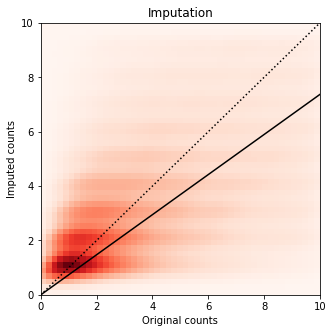

<Figure size 432x288 with 0 Axes>

In [10]:
# CORTEX 
cortex_vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * use_batches)
trainer_cortex = UnsupervisedTrainer(cortex_vae,
                                 cortex_dataset,
                                 train_size=0.9,
                                 use_cuda=use_cuda)

trainer_cortex.corrupt_posteriors(rate=0.1, corruption="binomial")
trainer_cortex.train(n_epochs=n_epochs)
trainer_cortex.uncorrupt_posteriors()

original_list, imputed_list = trainer_cortex.train_set.imputation_benchmark(
    n_samples=1, 
    show_plot=show_plot,
    save_path=save_path,
)

### Figure 11. imputation (Binomial Corruption)


- todo: add the summary of all the **binomial** imputation benchmarks (PBMC, RETINA, CORTEX, BRAIN-LARGE, HEMATO), computed elsewhere in the notebook.

(a) through (c): we investigate how scVI latent space can be used to impute the data (with the binomial perturbation scheme) and report bench- marking across datasets for state-of-the-art methods.

In [20]:
# load dataset 
datasets = [cortex_dataset, 
            retina_dataset, 
            pbmc_dataset, 
            hemato_dataset]

imputation_errors_binomial=dict()
n_epochs=250 if n_epochs_all is None else n_epochs_all

for dataset in datasets:
    vae = VAE(dataset.nb_genes, n_batch=dataset.n_batches * use_batches)
    trainer = UnsupervisedTrainer(vae,
                                  dataset,
                                  train_size=0.9,
                                  use_cuda=use_cuda)
    trainer.corrupt_posteriors(rate=0.1, corruption="binomial")
    trainer.train(n_epochs=n_epochs)
    trainer.uncorrupt_posteriors()
    
    imputation_errors_binomial[dataset.__class__.__name__] = trainer.train_set.imputation_score(n_samples=1)
    
print(imputation_errors_binomial)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data
File data/retina.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/gene_info_pbmc.csv already downloaded
File data/pbmc_metadata.pickle already downloaded
File data/HEMATO/bBM.raw_umifm_counts.csv.gz already downloaded
File data/HEMATO/data.zip already downloaded
Preprocessing Hemato data
Finished preprocessing Hemato data
training: 100%|██████████| 250/250 [01:55<00:00,  2.17it/s]
{'CortexDataset': 2.3004127, 'RetinaDataset': 2.303554, 'PbmcDataset': 2.3072965, 'HematoDataset': 2.290228}


### Figure 12. DE; plots

CD
Detected  217  genes with scVI
Detected  111  genes with microarray


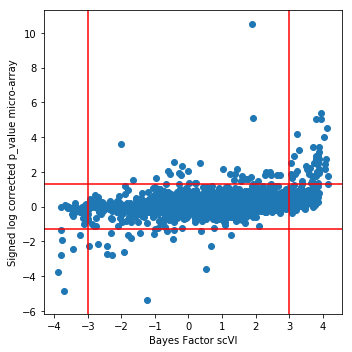

In [32]:
# PBMC 
interest = "CD"
couple_celltypes = (3, 2)
rank_auc = 111
p_prior = 0.03

p_value = pbmc_dataset.de_metadata[interest + "_adj.P.Val"]
signed_p_value = - np.log10(p_value) * np.sign(pbmc_dataset.de_metadata[interest + "_logFC"])

cell_a_idx = (pbmc_dataset.labels==3).ravel()
cell_b_idx = (pbmc_dataset.labels==2).ravel()
pbmc_trainer.posterior = pbmc_trainer.create_posterior(indices=np.arange(len(pbmc_dataset)))
n_samples = 200
M_permutation = 40000
st = pbmc_trainer.posterior.differential_expression_score(cell_a_idx,cell_b_idx,n_samples=n_samples, 
                                                          M_permutation=M_permutation,
                                                          all_stats=False)

plt.figure(figsize=(5, 5))
plt.scatter(st, signed_p_value)
plt.axvline(x=3, c="r")
plt.axvline(x=-3, c="r")
plt.axhline(y=np.log10(0.05), c="r")
plt.axhline(y=-np.log10(0.05), c="r")
plt.xlabel("Bayes Factor scVI")
plt.ylabel("Signed log corrected p_value micro-array")
plt.tight_layout()
#plt.savefig(interest + "_Bayes_factor_vs_micro_array.pdf", dpi=300)
print(interest)
print("Detected ", np.sum(2 * np.abs(st) >= 6), " genes with scVI")
print("Detected ", np.sum(p_value <= 0.05), " genes with microarray")

Text(0,0.5,'Percentage of genes in each bin')

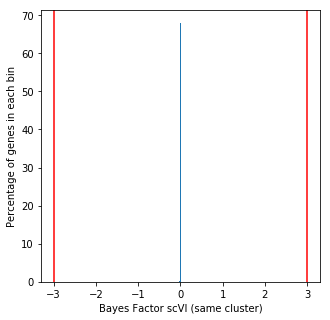

In [33]:
cell_a_idx = (pbmc_dataset.labels == 2).ravel()
cell_b_idx = (pbmc_dataset.labels == 2).ravel()
pbmc_trainer.posterior = pbmc_trainer.create_posterior(indices=np.arange(len(pbmc_dataset)))
n_samples = 200
M_permutation = 40000
st = pbmc_trainer.posterior.differential_expression_score(
    cell_a_idx,
    cell_b_idx,
    n_samples=n_samples,
    M_permutation=M_permutation,
    all_stats=False
)

plt.figure(figsize=(5, 5))
plt.hist(st, density=True)
plt.axvline(x=3, c="r")
plt.axvline(x=-3, c="r")
plt.xlabel("Bayes Factor scVI (same cluster)")
plt.ylabel("Percentage of genes in each bin")

### Figure 13. DE; plots

#### a) Originally found for PBMC dataset, but let's do it for Brain Small

This result was only obtained on the PBMC dataset

Text(0,0.5,'Percentage of matrix entries in that bin')

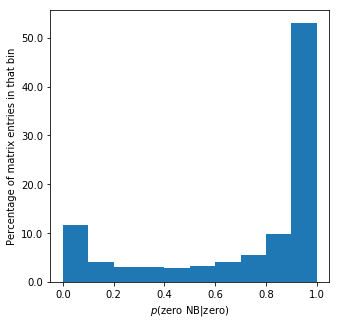

In [78]:
# PBMC
from matplotlib.ticker import FuncFormatter

dropout_list, mean_list, dispersion_list = pbmc_trainer.train_set.generate_parameters()

plt.figure(figsize=(5, 5))


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(10 * y)
    return s


p_nb = process_proba(dropout_list, mean_list, dispersion_list)
p_zi = process_proba(dropout_list)

ratio_prob = p_nb / (p_nb + p_zi - p_nb * p_zi)

plt.hist(ratio_prob.flatten(), bins=10, density=True)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel(r"$p($zero NB$ | $zero$)$")
plt.ylabel("Percentage of matrix entries in that bin")

#### b) c) d) BRAIN_SMALL

Text(0,0.5,'Proportion of zero entries in each cell')

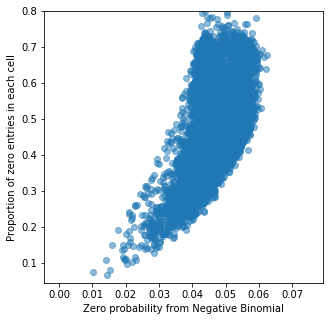

In [12]:
dropout_list, mean_list, dispersion_list = brain_small_trainer.train_set.generate_parameters()

p_nb = process_proba(dropout_list, mean_list, dispersion_list)
p_zi = process_proba(dropout_list)

ratio_prob = p_nb / (p_nb + p_zi - p_nb * p_zi)

plt.figure(figsize=(5, 5))
plt.scatter(
    np.mean(p_nb, axis=1),
    np.mean(brain_small_dataset.X[brain_small_trainer.train_set.indices] == 0, axis=1), 
    alpha=0.5,
)
plt.ylim((0.045, 0.8))
plt.xlabel("Zero probability from Negative Binomial")
plt.ylabel("Proportion of zero entries in each cell")

Text(0,0.5,'Genome not gene QC in each cell')

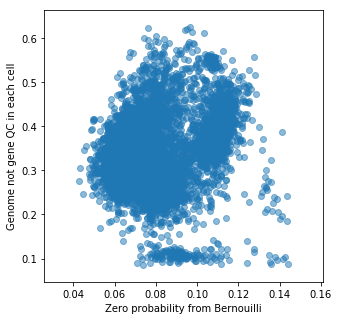

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(np.mean(p_zi, axis=1), brain_small_dataset.qc[brain_small_trainer.train_set.indices, 5], alpha=0.5)
# plt.ylim((0.045, 0.27))
plt.xlabel("Zero probability from Bernouilli")
plt.ylabel("Genome not gene QC in each cell")

Text(0,0.5,'Mapped reads QC in each cell')

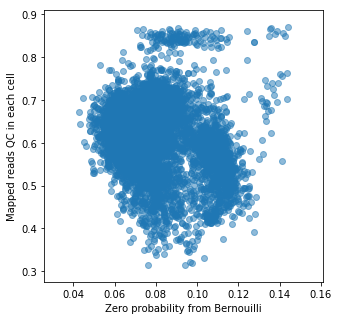

In [14]:
plt.figure(figsize=(5, 5))
plt.scatter(np.mean(p_zi, axis=1), brain_small_dataset.qc[brain_small_trainer.train_set.indices, 4], alpha=0.5)
# plt.ylim((0.045, 0.27))
plt.xlabel("Zero probability from Bernouilli")
plt.ylabel("Mapped reads QC in each cell")

### Figure 14. imputation 

#### a) b) c) Brain Large

In [9]:
# import h5py
# data_path = "/home/ubuntu/data_small.hdf5"
# f = h5py.File(data_path)
# expression_train = f["data_train"][:10000]
# expression_test = f["data_test"][:10000]
# data_path = "/home/ubuntu/"
# X_zero, i, j, ix = \
#         np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
#         np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")

In [5]:
# BRAIN_LARGE, CORTEX

sample_size_gene_var = 10000 if n_epochs_all is None else 10
brainlarge_dataset = BrainLargeDataset(
    save_path=save_path, 
    sample_size_gene_var=sample_size_gene_var
) # Subsampled to 720 genes
gene_dataset = brainlarge_dataset
gene_dataset.dense=True
gene_dataset.X = brainlarge_dataset.X.A

In [16]:
batch_size = 128
learning_rate = 0.005
epsilon = 0.01

range_d = [2, 5, 7, 10, 12, 15, 20, 30]
results = {}

n_trials = 4
n_epochs = 120 if n_epochs_all is None else n_epochs_all

for d in range_d:
    results[d] = []
    for _ in range(n_trials):
        vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches, n_latent=d)
        train_size = min(10000, gene_dataset.X.shape[0]-1)
        trainer = UnsupervisedTrainer(vae,
                                      gene_dataset,
                                      train_size=train_size,
                                      use_cuda=use_cuda)

        trainer.corrupt_posteriors(rate=.1, corruption="uniform")
        trainer.train(n_epochs)
        trainer.uncorrupt_posteriors()
        
        results[d].append(trainer.train_set.imputation_score())

training: 100%|██████████| 120/120 [02:28<00:00,  1.24s/it]


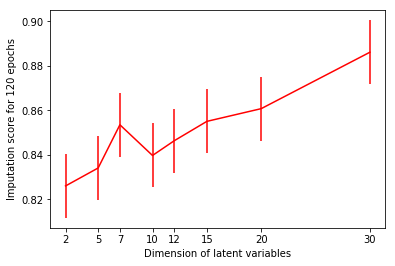

In [18]:
import numpy as np
import matplotlib.pyplot as plt

N = 8
means = np.mean(np.array(list(results.values())), axis=1)
std = np.std(np.array(list(results.values())), axis=1)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.errorbar(results.keys(), means, color='r', yerr=std[0])

# add some text for labels, title and axes ticks
ax.set_ylabel('Imputation score for 120 epochs')
ax.set_xticks(list(results.keys()))
ax.set_xlabel("Dimension of latent variables")

In [ ]:
vae = VAE(brainlarge_dataset.nb_genes)

trainer_brain_large = UnsupervisedTrainer(vae, brainlarge_dataset, frequency=1)

train_size_brain_large = 10000 if n_epochs_all is None else 5
trainer_brain_large.train_set = trainer_brain_large.create_posterior(indices=np.arange(train_size_brain_large))
trainer_brain_large.test_set = trainer_brain_large.create_posterior(
    indices=np.arange(train_size_brain_large, 2*train_size_brain_large)
)
trainer_brain_large.train_set.to_monitor = ['imputation_score', 'reconstruction_error']
trainer_brain_large.test_set.to_monitor = ['reconstruction_error']
n_epoch = 120 if n_epochs_all is None else n_epochs_all

trainer_brain_large.corrupt_posteriors(rate=0.2, corruption="binomial")
# gene_dataset.corrupted_X = np.ascontiguousarray(gene_dataset.corrupted_X.A, dtype=np.float32)
trainer_brain_large.train(n_epoch)
trainer_brain_large.uncorrupt_posteriors()

training:  18%|█▊        | 21/120 [04:00<18:54, 11.46s/it]

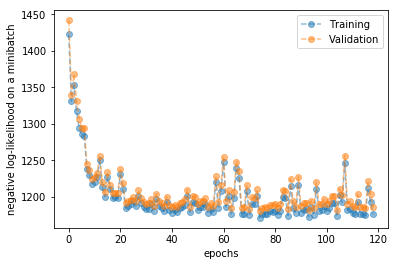

In [19]:
plt.plot(
    trainer_brain_large.history["reconstruction_error_train_set"][2:],  
    marker='o', 
    linestyle='--', 
    label="Training", 
    alpha=0.5
)
plt.plot(
    trainer_brain_large.history["reconstruction_error_test_set"][2:],  
    marker='o', 
    linestyle='--', 
    label="Validation", 
    alpha=0.5
)
plt.legend()
plt.ylabel("negative log-likelihood on a minibatch")
plt.xlabel("epochs")

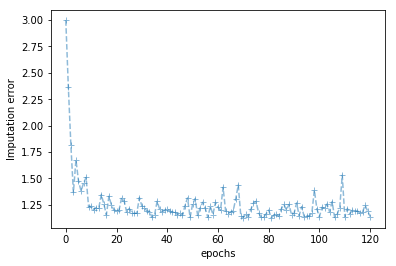

In [20]:
history_impute = trainer_brain_large.history['imputation_score_train_set']

print("Last value of the imputation error :", history_impute[-1])

plt.plot(history_impute,  marker='+', linestyle="--", alpha=0.5)
plt.ylabel("Imputation error")
plt.xlabel("epochs")

#### d )

In [ ]:
res = np.zeros((5, 6, 3))
latent_d = [2, 5, 7, 10, 15, 20]
n_epochs= 250 if n_epochs_all is None else n_epochs_all
epsilon=0.01
for j, d in enumerate(latent_d):
    for t in range(5):
        cortex_vae = VAE(cortex_dataset.nb_genes, n_batch=cortex_dataset.n_batches * use_batches, n_latent=d)
        trainer_cortex = UnsupervisedTrainer(
            cortex_vae,
            cortex_dataset,
            train_size=0.75,
            use_cuda=use_cuda
        )
        trainer_cortex.train(n_epochs=n_epochs, lr=lr, eps=epsilon)
        
        asw_score, nmi_score, ari_score, uca_score = trainer_cortex.train_set.clustering_scores()
        res[t,j] = asw_score, ari_score, nmi_score

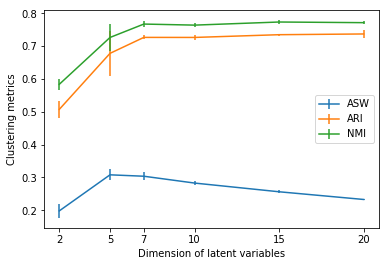

In [19]:
import numpy as np
import matplotlib.pyplot as plt

N = 8

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

label = ["ASW", "ARI", "NMI"]

fig, ax = plt.subplots()
for i in [0, 1, 2]:
    ax.errorbar(latent_d, np.mean(res[:, :, i], axis=0), yerr=np.std(res[:, :, i], axis=0), label=label[i])

# add some text for labels, title and axes ticks
ax.set_ylabel('Clustering metrics')
ax.set_xticks(latent_d)
ax.set_xlabel("Dimension of latent variables")
plt.legend()

plt.savefig(os.path.join(save_path, "zeiler_clustering_dimension_stability.pdf"), dpi=300)

### Figure 15. clustering

For the random data, we obtain the labels that order the cell-cell similarity matrices by a k means clustering on SIMLR latent space.

#### a) scVI latent space with SIMLR labels. There is no structure

mu 4.0 theta 2.0 r 2.0 p 0.6666666666666666 dropout 0.7
File data/random_metadata.pickle already downloaded
training: 100%|██████████| 120/120 [00:15<00:00,  7.98it/s]


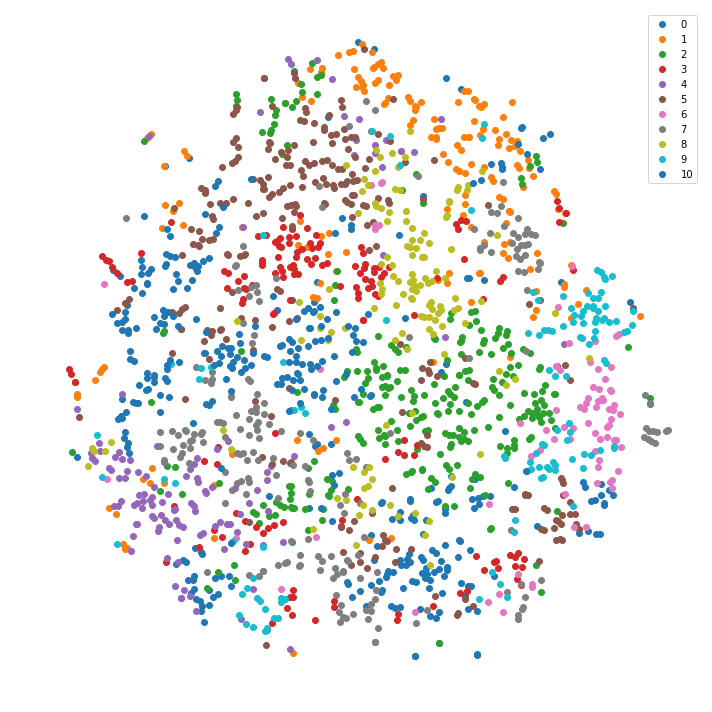

In [23]:
# random and HEMATO
n_epochs = 120 if n_epochs_all is None else n_epochs_all
synthetic_dataset = SyntheticRandomDataset(save_path=save_path)
vae = VAE(synthetic_dataset.nb_genes)
trainer_synthetic = UnsupervisedTrainer(vae, synthetic_dataset, train_size=1.0)
trainer_synthetic.train(n_epochs)

trainer_synthetic.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

#### b) SIMLR latent space with SIMLR labels

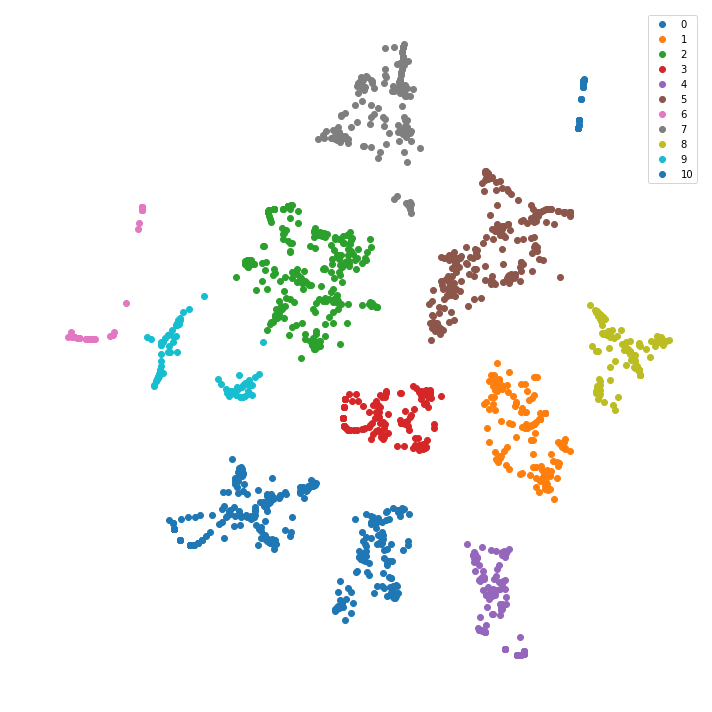

In [7]:
trainer_synthetic.train_set.show_t_sne(latent=synthetic_dataset.simlr_metadata['ydata'][:n_samples_tsne], 
                                       labels=synthetic_dataset.labels.ravel()[:n_samples_tsne], color_by='labels')

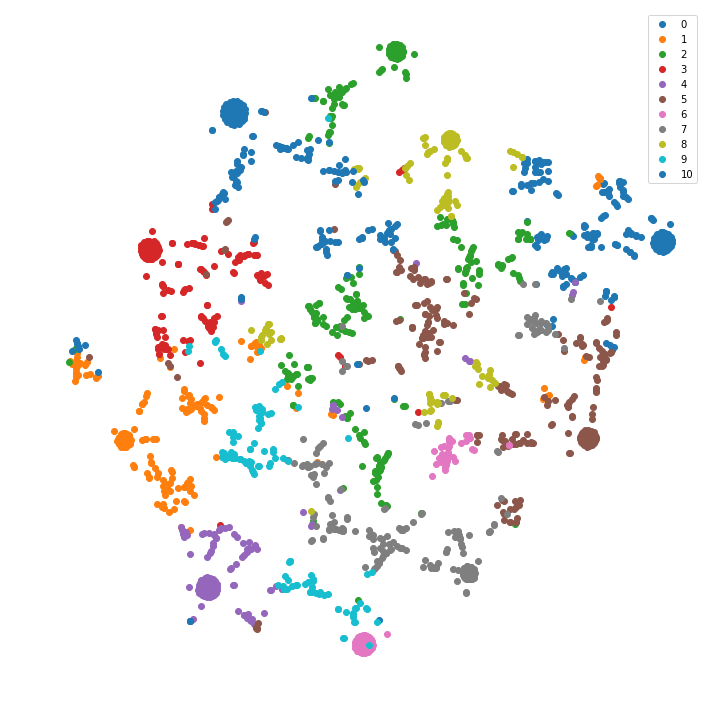

In [13]:
from sklearn.decomposition import PCA
n_latent=10
pca = PCA(n_components=n_latent)
data = synthetic_dataset.X[:n_samples_tsne]
X = pca.fit_transform(np.log(1 + data / np.sum(data, axis=1)[:, np.newaxis]))
latent_pca, _ = trainer_synthetic.train_set.apply_t_sne(X, n_samples=None)
trainer_synthetic.train_set.show_t_sne(
    latent=latent_pca, 
    labels=synthetic_dataset.labels.ravel()[:n_samples_tsne], 
    color_by='labels'
)

### Figure 16. tsne

On the Hemato dataset, already loaded above

In [23]:
# set hyperparameters 
n_epochs=200 if n_epochs_all is None else n_epochs_all
lr=0.0004
use_batches=False
use_cuda=True

n_latent = 60
# train the model 
hemato_vae = VAE(hemato_dataset.nb_genes, n_batch=hemato_dataset.n_batches * use_batches, n_latent=n_latent)
hemato_trainer = UnsupervisedTrainer(hemato_vae,
                                     hemato_dataset,
                                     train_size=0.9, 
                                     use_cuda=use_cuda, 
                                     frequency=0)


hemato_trainer.train(n_epochs=n_epochs, lr=lr)
# visualize latent space 
hemato_trainer.full_dataset = hemato_trainer.create_posterior(shuffle=False)
latent_hemato, _ = hemato_trainer.full_dataset.apply_t_sne(
    hemato_trainer.full_dataset.get_latent()[0], 
    n_samples=None
)

training: 100%|██████████| 200/200 [01:39<00:00,  2.01it/s]


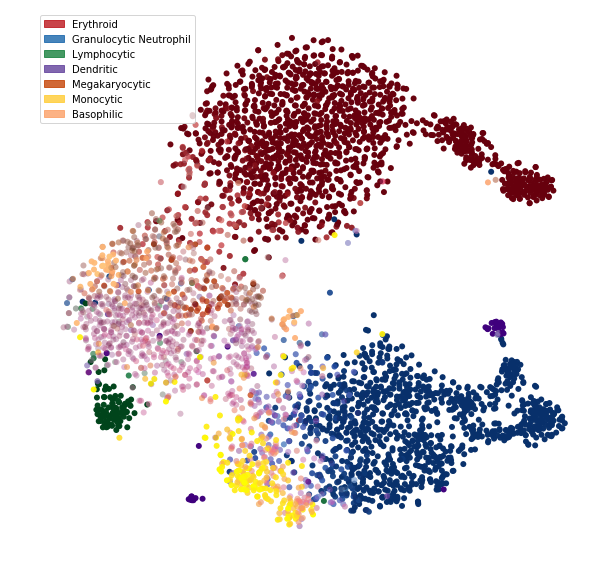

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

meta = hemato_dataset.meta


def alpha_cmap(cmap, min_alpha=-1, max_alpha=1):
    cm = plt.get_cmap(cmap)
    cm._init()
    alphas = np.abs(np.linspace(0.0, 1.0, cm._lut[:,-1].shape[0]))
    cm._lut[:,-1] = alphas
    return cm


def plot_layout(layout=None):
    plt.figure(figsize=(10, 10))
    patches = [] 
    for i, (color, cell_type) in enumerate(zip(
        ["Reds", "Blues", "Greens", "Purples", "Oranges", "spring", 'copper'],
        ['Erythroid', 'Granulocytic Neutrophil', 'Lymphocytic', 'Dendritic', 'Megakaryocytic', 'Monocytic', 
         'Basophilic'])):
        patches+=[mpatches.Patch(color=plt.get_cmap(color)(.8), label=cell_type)]
        plt.scatter(layout[:, 0], layout[:, 1], c=meta.iloc[:, i+1],cmap=alpha_cmap(color), label=cell_type, 
                    edgecolors='none')
    plt.legend(handles=patches)
    plt.axis("off")

plot_layout(latent_hemato)

In [ ]:
def allow_notebook_for_test():
    print("Testing the scVI reproducibility notebook")